## Hypercolumn Model (Hcol) - Ver1

* Hypercolumn Model (Hcol) - Ver1, hypercolumn extraction on VGG16 and then K-means + VLAD encoder to calculate residuals, classified with ensemble method using GradientBoosting from sklean lib.
* This version is the similified version for a quick test, the optimization and visualization methods (PCA, t-SNE & confusion matrix) are the same as LS model anmd can be found under LinearSoftmax (LS) - Ver0.
* Training and testing on NIOSH nanocarbon dataset with 4000+ TEM images, achieved 90% on 4-class

### Python Lib Version List (tested and recommended, other latest version may works as well)
* Python 3.6.8
* Numpy 1.16.2
* Matplotlib 3.0.2
* Scipy 1.2.1
* Keras 2.2.4
* Scikit-image 0.14.2
* Scikit-learn 0.20.2
* Pillow 5.4.1

In [1]:
import os
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

from scipy.misc import imresize, bytescale, imsave
from skimage.color import gray2rgb

import keras.backend as K
from keras.models import Model
from keras.applications import vgg16

from keras.layers import Input, Dense, Lambda
from keras import optimizers

from random import shuffle

from PIL import Image

import tensorflow as tf
from sklearn.cluster import MiniBatchKMeans
import pickle
import random

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

import time

Using TensorFlow backend.


### Loading Modulus (Same as LS model)
* target folder - data directory of the project, placed under the same root directory of this notebook, named as 'data_folder'
* class_folder - categorical folder under data directory, placed under target_folder, named by each individual CNT class
* PC configuration: 
    - CPU - i7-8700K
    - GPU - RTX2070
    - RAM - 32GB
* Takes about 3mins loading 3200 images
* Output:
    - train/test_list: text file of train/test image names
    - train/test_images: np array of train/test image names
    - train/test_labels: np array of train/test image labels

In [16]:
def load_NIOSH(filenames_path):
    #load images from paths specified in filenames to a np array
    #return the np array, and an array of labels as a np array
    #preprocess the images for vgg use as well
    # 4 CLASS
    target_folder = 'data_folder'
    label_dict = dict()
    label_dict['CNT-Cluster'] = [1, 0, 0, 0]
    label_dict['CNT-fiber'] = [0, 1, 0, 0]
    label_dict['CNT-Matrix'] = [0, 0, 1, 0]
    label_dict['CNT-MatrixSurface'] = [0, 0, 0, 1]

    filenames = open(filenames_path, 'r')
    filenames_list = filenames.readlines()
    filenames.close()

    images = []
    image_labels = []
    for filename in filenames_list:
        filename = filename.strip()
        label_key = os.path.split(filename)[0] 
        image = io.imread(os.path.join(target_folder, filename))
        #preprocess the image for vgg16
        image = imresize(image, (224, 224))
        image = gray2rgb(image)
        label = label_dict[label_key]
        images.append(image)
        image_labels.append(label)
    return vgg16.preprocess_input(np.array(images)), np.array(image_labels)

In [20]:
def run():
    target_folder = 'data_folder'
    class_folders = ['CNT-Cluster', 'CNT-fiber', 'CNT-Matrix', 'CNT-MatrixSurface']
    # 80%train+20%test
    num_images = [800, 800, 800, 800]

    train_list = open('train.txt', 'w')
    for i, class_folder in enumerate(class_folders):
        filenames = os.listdir(os.path.join(target_folder, class_folder))
        #get a random shuffle of the filenames
        shuffle(filenames)
        for j in range(num_images[i]):
            train_list.write(os.path.join(class_folder, filenames[j]) + '\n')
    train_list.close()

    train_images, train_labels = load_NIOSH('train.txt')

    np.save('train_images.npy', train_images)
    np.save('train_labels.npy', train_labels)

    train_labels = np.load('train_labels.npy')

In [21]:
def linearsoftmax():
    localtime = time.asctime( time.localtime(time.time()) )
    start = time.time()
    print("Loading images started: {}".format(localtime))
    run()
    # counting time
    print("Loading images ended: {}".format(localtime))
    end = time.time()
    print("Takes {} minutes to load images".format((end-start)/60))

In [22]:
linearsoftmax()

Loading images started: Mon Jun  8 09:12:05 2020


E:\Tools\Anaconda\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Loading images ended: Mon Jun  8 09:12:05 2020
Takes 2.7991181373596192 minutes to load images


### Hypercolumn Extraction Modulus
* Func1&2 - helper functions for reshaping Hcol and vectorization, plus sum the dimension for final Hcol
* Func3 - build hcol model network as model

In [23]:
#helper for the hypercolumn network - reshapes all of the inputs to the same
#shape as the first one, then concatenates them into one vector
def bilinear_upsample(input_list):
    results_list = [input_list[0]]
    shape = input_list[0].get_shape()[1:3]
    for i in range(len(input_list[1:])):
        inputs = input_list[i + 1]
        #use tensorflow to resize the inputs to the same shape as the first one,
        #using the default bilinear interpolation method
        results = tf.image.resize_images(inputs, shape)
        results_list.append(results)
    #concatenate all of the resized inputs together to make the hypercolumns
    hcols = K.concatenate(results_list, axis=-1)
    return hcols

In [24]:
#helper for the hypercolumn network, determines the shape of the hypercolumn from its inputs
#the hypercolumn shape is the shape of the first input (x by y with 3 dimensions), with the 
#4th dimension summed across all of the inputs
def upsampled_shape(input_shapes):
    summation = int(np.sum([shape[-1] for shape in input_shapes]))
    shape = input_shapes[0]
    return (shape[0], shape[1], shape[2], summation)

In [25]:
#create the hypercolumn network, to produce the hypercolumns
def vgg_hcol_network():
    vgg = vgg16.VGG16(include_top=True, weights='imagenet')
    inputs = vgg.input
    #x is the block1_conv1 layer, connected to the input layer
    x = vgg.get_layer(index=1)(inputs)
    #the rest of the vgg layers from block1_conv2 onward
    layers = vgg.layers[2:]
    #list of indices in the layers list above, corresponding 
    #to b1c2, b2c2, b3c3, b4c3, and b5c3 
    indices = [0, 3, 7, 11, 15]
    output_list = []
    for index, layer in enumerate(layers):
        #set the trainable weights in each layer to be untrainable
        #make sure the border mode is set to same 
        layer._non_trainable_weights = layer._trainable_weights
        layer._trainable_weights = []
        layer.border_mode = 'same'
        #if the layer is one of the ones specified above, save its output
        x = layer(x)
        if index in indices:
            output_list.append(x)
    #create a new layer that combines all of the saved outputs from above
    outputs = Lambda(bilinear_upsample, output_shape=upsampled_shape)(output_list) 
    model = Model(inputs=inputs, outputs=outputs)
    opt = optimizers.Adam(lr=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [26]:
 hcol_net = vgg_hcol_network()

### Hypercolumn Processing Modulus
* Func1 - creating K-means dictionary to do mapping for hcol vectors
* Func2 - encoding hcol vectors using VLAD descriptor
* Func3 - calculating on residuals of each hcol vector on K-means clustering, encoded by VLAD

In [27]:
#there are 4259 train images and 1064 test images. Need to build up the kmeans dictionary 
#in parts to prevent memory issues
possible_coords = []
for x in range(224):
    for y in range(224):
        possible_coords.append((x, y))

In [28]:
#create the kmeans dictionary for the vlad encoding below, using a 100 cluster 
#partial fit on batches of one image, and using num_hcols hcols per image. 
def create_kMeans(images, num_hcols):
    kMeans = MiniBatchKMeans(n_clusters = 100)
    for i in range(images.shape[0]):
        img = images[i]
        img = np.expand_dims(img, 0)
        hcols = hcol_net.predict(img, batch_size=1)
        #pull num_hcols random hypercolumns from the network (for each image) and use 
        #them to build the kMeans dictionary
        sample_coords = random.sample(possible_coords, num_hcols)
        sample_hcols = []

        for j in range(num_hcols):
            coords = sample_coords[j]
            hcol = hcols[0][coords[0]][coords[1]]
            sample_hcols.append(hcol)

        sample_hcols = np.stack(sample_hcols)
        kMeans.partial_fit(sample_hcols)
        print('Finished fitting for images with percentage: {:.2%}'.format((i+1)/images.shape[0]), end="\r")
    print('\n')
    return kMeans

In [29]:
#vlad encoding function
def vlad_encode(features,dictionary):
    labels = dictionary.predict(features)
    residuals = []
    for mode in range(len(dictionary.cluster_centers_)):
        cluster_center = dictionary.cluster_centers_[mode]
        x_mode = features[labels==mode]
        if len(x_mode)==0:
            residuals.append(np.zeros(cluster_center.shape[-1]))
        else:
            residual = np.sum(x_mode-cluster_center,axis=0)
            if np.linalg.norm(residual) != 0:
                residual = residual/np.linalg.norm(residual)
            residuals.append(residual)
    residuals = np.concatenate(residuals,axis=-1)
    return residuals/np.linalg.norm(residuals)

In [30]:
#create the vlad numpy array of vlad data from the image data
#uses the hcol network and kmeans dictionary constructed above
#and current is set to use num_hcols random hcols per image
def create_vlad(inputs, kMeans, num_hcols):
    vlad_list = []
    for i in range(inputs.shape[0]):
        img = inputs[i]
        img = np.expand_dims(img, 0)
        hcols = hcol_net.predict(img, batch_size=1)
        sample_coords = random.sample(possible_coords, num_hcols)
        sample_hcols = []
        for j in range(num_hcols):
            coords = sample_coords[j]
            hcol = hcols[0][coords[0]][coords[1]]
            sample_hcols.append(hcol)
        sample_hcols = np.stack(sample_hcols)
        vlad_list.append(vlad_encode(sample_hcols, kMeans))
        print('Finished vlad encoded images with percentage: {:.2%}'.format((i+1)/inputs.shape[0]), end="\r")
    print('\n')
    vlad = np.stack(vlad_list)
    return vlad

### Training modulus
* Whole training process through loading images, extracting Hcol into vectors, K-means creating, VLAD encoding and residual calculation for hcol vectors, finally periodicly trainned on GradientBoosting classifier, the output is the K-means dictionary using for clustering, and training resulted in strong GradBoost classifier.
* Takes about 4 hours on 3200 images with 10% hypercolumn density
* Input:
    - train_labels and train_images from the loading modulus at top
* Output:
    - kmeans file: kmeans dictionary created for clustering hcol vectors
    - GradientBoosting file: the final classifier after training on GradientBoosting ensemble method

In [31]:
def VGG_hcols_train(Density):
    localtime = time.asctime( time.localtime(time.time()) )
    start = time.time()
    print("Program Started: {}".format(localtime))

    num_hcols = Density * 500
    # 1% density as 500 hcols, then num_hcols = 500 * density
    print("Density = {}%.".format(Density))

    #load all of the previously generated testing and training images and labels
    #images are preprocessed for vgg as 224x224 rgb, and the labels are binary 
    train_labels = np.load('train_labels.npy')
    train_images = np.load('train_images.npy')

    kMeans = create_kMeans(train_images, num_hcols)
    kMeans_fd = open('kMeans.p', 'wb')
    pickle.dump(kMeans, kMeans_fd)
    kMeans_fd.close()
    print("saved kmeans\n")

    vlad_train = create_vlad(train_images, kMeans, num_hcols)
    np.save('vlad_train.npy', vlad_train)
    print("saved vlad train\n")
    
    train_label_indices = np.argmax(train_labels, axis=1)
    print("read train labels\n")
    
    print("Working on grad boosting classifier on vlad train data, this may takes long...\n")
    #reate and save the grad boosting classifier
    grad_boost_model = GradientBoostingClassifier()
    grad_boost_model.fit(vlad_train, train_label_indices)
    #save the classifier
    grad_boost_fd = open('grad_boost_model.p', 'wb')
    pickle.dump(grad_boost_model, grad_boost_fd)
    grad_boost_fd.close()
    print("fitted and saved grad boosting classifier on vlad train data\n")
       
    #predict using the grad boosting model 
    train_preds = grad_boost_model.predict(vlad_train)

    # counting time
    print("Program ended: {}".format(localtime))
    end = time.time()
    print("Finish training - this progress takes {} minutes,".format((end-start)/60))
    print("Or {} hours to run!".format((end-start)/3600))

In [32]:
print("Please set density of hcols:")
den = int(input())
VGG_hcols_train(den)

Please set density of hcols:
10
Program Started: Mon Jun  8 09:15:36 2020
Density = 10%.
Finished fitting for images with percentage: 100.00%

saved kmeans

Finished vlad encoded images with percentage: 100.00%

saved vlad train

read train labels

Working on grad boosting classifier on vlad train data, this may takes long...

fitted and saved grad boosting classifier on vlad train data

Program ended: Mon Jun  8 09:15:36 2020
Finish training - this progress takes 239.317181233565 minutes,
Or 3.9886196872260835 hours to run!


### Testing modulus
* Takes just few ms on each image
* Follow the same pipeline for training, but predicted with pre-trained GradBoost classifier.
* Input:images in the test folder and files created from training modulus
    - test_folder: test data directory for images, placed under the data_folder, named as 'TEST' for our case.
    - Previous K-means: 'kMeans.p'
    - Previous trained GradientBoosting classifier: 'grad_boost_model.p'
* Output:images, predicted label, time cost and accuracy

In [42]:
def load_test(filenames_path):
    from PIL import Image, ImageOps
    #load images from paths specified in filenames to a np array
    #return the np array, and an array of labels as a np array
    #preprocess the images for vgg use as well
    target_folder = 'data_folder'
    filenames = open(filenames_path, 'r')
    filenames_list = filenames.readlines()
    filenames.close()

    images = []
    for i, filename in enumerate(filenames_list):
        filename = filename.strip()
        image = io.imread(os.path.join(target_folder, filename))
        #preprocess the image for vgg16
        image = imresize(image, (224, 224))
        image = gray2rgb(image)
        images.append(image)
        im = Image.open(os.path.join(target_folder, filename))
        im = ImageOps.fit(im, (224, 224), Image.ANTIALIAS)
        display(im)
        print("Figure {}: {}".format(i+1, filename.replace('TEST\\', '')))
    return vgg16.preprocess_input(np.array(images))

In [43]:
def preprocess_test():
    # find selected test image in path
    target_folder = 'data_folder'
    test_list = open('test.txt', 'w')
    test_folder = 'TEST'
    test_filenames = os.listdir(os.path.join(target_folder, test_folder))
    for i in range(len(test_filenames)):
        test_list.write(os.path.join(test_folder, test_filenames[i]) + '\n')
    test_list.close()

    # load test image and pre-trainned weights
    test_images = load_test('test.txt')
    return test_images, test_filenames

In [44]:
def run_test(Density):
    num_hcols = Density * 500
    # 1% density as 500 hcols, then num_hcols = 500 * density
    print("Density = {}%.".format(Density))

    #load all of the previously generated testing and training images and labels
    #images are preprocessed for vgg as 224x224 rgb, and the labels are binary 
    test_images, test_filenames = preprocess_test()

    kMeans_fd = open('kMeans.p', 'rb')
    kMeans = pickle.load(kMeans_fd)
    kMeans_fd.close()
    print("Read kmeans\n")

    #load the grad boosting model
    grad_boost_fd = open('grad_boost_model.p', 'rb')
    grad_boost_model = pickle.load(grad_boost_fd)
    grad_boost_fd.close()
    print("load grad boosting model\n")

    #vlad encode the testing data
    vlad_test = create_vlad(test_images, kMeans, num_hcols)
    print("Finish vlad test encoding\n")

    #predict using the grad boosting model 
    pred = grad_boost_model.predict(vlad_test)
    print("Finish test prediction on grad_boost classifier\n")
    
    return pred, test_filenames

In [45]:
def main():
    # counting time
    localtime = time.asctime(time.localtime(time.time()))
    start = time.time()
    print('Program Started: {}'.format(localtime))
    print('Run testing for {}% Hcol model:'.format(den))

    pred, test_list = run_test(den)
    
    # counting time
    print('Program ended: {}'.format(localtime))
    end = time.time()
    print(pred)
    print(test_list)
    num=len(test_list)
    print(num)
    print('This progress takes {} seconds to run, totally {} images are processed, average {:.2f} second(s) per image!'.format(end-start, num, (end-start)/num))
    
    label_dict = {0:'CNT-Cluster', 1:'CNT-Fiber', 2:'CNT-Matrix', 3:'CNT-MatrixSurface'}
    Cl_prob = np.count_nonzero(pred == 0)/num
    Fi_prob = np.count_nonzero(pred == 1)/num
    Ma_prob = np.count_nonzero(pred == 2)/num
    MS_prob = np.count_nonzero(pred == 3)/num
    print('\nThere are {} images been processed, classified as {:.2%} CNT-Cluster, {:.2%} CNT-Fiber, {:.2%} CNT-Matrix and {:.2%} CNT-MatrixSurface.'
    .format(num, Cl_prob, Fi_prob, Ma_prob, MS_prob))
    for i, test_name in enumerate(test_list):
        print('The predicted label for No.{} - {} is {}.'.format(i+1, test_name, label_dict[pred[i]]))

Program Started: Mon Jun  8 13:27:40 2020
Run testing for 10% Hcol model:
Density = 10%.


E:\Tools\Anaconda\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  app.launch_new_instance()


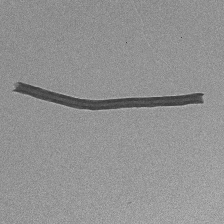

Figure 1: FIBER.tif


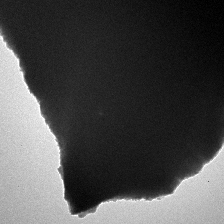

Figure 2: MATRIX-SURFACE.tif


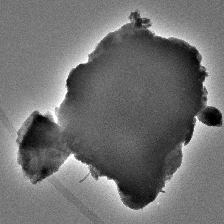

Figure 3: MATRIX.tif
Read kmeans

load grad boosting model

Finished vlad encoded images with percentage: 100.00%

Finish vlad test encoding

Finish test prediction on grad_boost classifier

Program ended: Mon Jun  8 13:27:40 2020
[1 3 2]
['FIBER.tif', 'MATRIX-SURFACE.tif', 'MATRIX.tif']
3
This progress takes 2.0837039947509766 seconds to run, totally 3 images are processed, average 0.69 second(s) per image!

There are 3 images been processed, classified as 0.00% CNT-Cluster, 33.33% CNT-Fiber, 33.33% CNT-Matrix and 33.33% CNT-MatrixSurface.
The predicted label for No.1 - FIBER.tif is CNT-Fiber.
The predicted label for No.2 - MATRIX-SURFACE.tif is CNT-MatrixSurface.
The predicted label for No.3 - MATRIX.tif is CNT-Matrix.


In [46]:
if __name__ == '__main__':
    main()